# 1、读取数据
使用numpy读出数据,数据值的范围是[0,255]

In [5]:
import numpy as np
import pandas as pd

TRAIN_DATAPATH = "../data/MNIST/experiment_09_training_set.csv"
TEST_DATAPATH = "../data/MNIST/experiment_09_testing_set.csv"

train_data = pd.read_csv(TRAIN_DATAPATH)
test_data = pd.read_csv(TEST_DATAPATH)
train_data = np.array(train_data).astype(np.float32)
test_data = np.array(test_data).astype(np.float32)

train_x = train_data[:,1:].reshape(-1,28,28)
train_y = train_data[:,0].reshape(-1,1).astype(np.int32)
# # 打印每个标签及其对应的频数
# label_counts = np.bincount(train_y.reshape(-1))
# for label, count in enumerate(label_counts):
#     print(f"Label {label}: Count {count}")
train_y = np.eye(10)[train_y.reshape(-1)].astype(np.float32)

test_x = test_data[:,1:].reshape(-1,28,28)
test_y = test_data[:,0].reshape(-1,1).astype(np.int32)
test_y = np.eye(10)[test_y.reshape(-1)].astype(np.float32)
print(np.unique(train_x))
print(train_x.shape)
print(train_y.shape)
print(train_y.dtype)
print(test_x.shape)
print(test_y.shape)
print(test_y.dtype)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

# 2、查看数据
以灰度图的形式展示数据

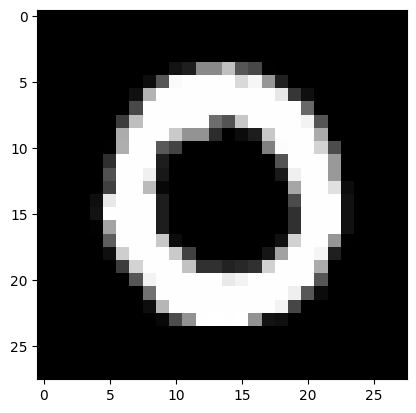

In [6]:
import matplotlib.pyplot as plt

img = train_x[1].reshape(28,28)
plt.imshow(img,cmap='gray')

# 3、将numpy数组转换成Dataset，并完成数据集划分
- 定义数据预处理，归一化到[0,1]
- 将2000张图片用于测试

In [7]:
import torch
from torch.utils.data import Dataset
import torch.utils.data as data
import torchvision.datasets as datasets
from torchvision import transforms
import torch.nn.functional as F

class NumpyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        label = self.labels[index]
        if self.transform:
            data = self.transform(data)
        return data, label
# 计算均值和标准差
mean = train_x.mean() / 255
std = train_x.std() / 255
print(mean)
print(std)
# 定义数据预处理
traintransforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        # transforms.Normalize(mean=[mean], std=[std]),
                                      ])
# 创建NumpyDataset实例
traindataset = NumpyDataset(train_x, train_y, transform=traintransforms)
testdataset = NumpyDataset(test_x, test_y, transform=traintransforms)
print(len(traindataset))
print(len(testdataset))
BATCH_SIZE = 64
# 创建DataLoader
trainloader = data.DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = data.DataLoader(testdataset, batch_size=2000, shuffle=True)

0.13108918433095895
0.3086172664866728
40000
2000


# 4、模型组网
- 参考LeNet-5的结构,将最后一层的RBF改成了全连接+Softmax，输入大小与原论文不一致
- 模型结构图<img src = "./asserts/model.jpg"> 
- 参考论文地址:[Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)
- 改进后的网络结构图
- <img src="./asserts/model1.png" width = 800>

In [19]:
import torch.nn as nn
import torch.nn.functional as F
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        # 模型结构
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) # 28*28*1 -> 24*24*6
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # 24*24*6 -> 12*12*6
        self.relu = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # 12*12*6 -> 8*8*16
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) # 8*8*16 -> 4*4*16
        self.fc5 = nn.Linear(in_features=4*4*16, out_features=120) # 4*4*16 -> 120
        self.fc6 = nn.Linear(in_features=120, out_features=84) # 120 -> 84
        self.softmax = nn.Softmax(dim=1)
        self.out = nn.Linear(in_features=84, out_features=10) # 84 -> 10
    def forward(self,X):
        # C1
        X = self.conv1(X)
        # S2
        X = self.maxpool2(X)
        X = self.relu(X) 
        # C3
        X = self.conv3(X)
        # S4
        X = self.maxpool4(X)
        X = self.relu(X)  
        # flatten
        X = X.view(X.shape[0],-1) # flatten
        # F5
        X = self.fc5(X)
        X = self.relu(X) 
        # F6
        X = self.fc6(X)
        X = self.relu(X) 
        # OUTPUT
        X = self.out(X)
        X = self.softmax(X)
        return X

In [20]:
import torchsummary as summary
model = LeNet()
summary.summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
              ReLU-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
         MaxPool2d-5             [-1, 16, 4, 4]               0
              ReLU-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
          Softmax-12                   [-1, 10]               0
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
---------------------------------

# 5、 训练模型
## 优化器选择
使用三种不同的优化器完成训练
- SGD
- Adam
- RMSProp
## 学习率选择
分别在三种不同的优化器上，使用三种不同的学习率完成
- 0.01
- 0.001
- 0.0001
## 总共可以训练得到 9 个模型
## 损失函数采用MSE loss

In [9]:

# 定义优化器
import torch.optim as optim
model = LeNet()
LR_RATE = 0.1 
OPTIMIZER = "SGD"
OUTPUT_PATH = "LeNet/output/"
EPOCHS = 1000

if OPTIMIZER == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=LR_RATE)
elif OPTIMIZER == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
elif OPTIMIZER == "RMSprop":
    optimizer = optim.RMSprop(model.parameters(), lr=LR_RATE)
else:
    raise NotImplementedError("Optimizer is not implemented.")
# 损失函数
criterion  = nn.CrossEntropyLoss()

In [10]:
import torch
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score

# 计算准确率
def cal_acc(y_pred,y_true):
    # 将预测标签转换为与真实标签相同的数据类型
    y_pred = y_pred.argmax(dim=1).type_as(y_true)
    y_true = y_true.argmax(dim=1)
    # 比较预测标签和真实标签并计算准确度
    correct = torch.sum(y_pred == y_true).item()
    total = y_true.shape[0]
    accuracy = correct / total
    return accuracy
# 计算精确率
def cal_precision(y_pred,y_true):
    # 将预测标签转换为与真实标签相同的数据类型
    y_pred = y_pred.argmax(dim=1).type_as(y_true)
    y_true = y_true.argmax(dim=1)
    # 计算精确率
    precision = precision_score(y_true, y_pred,average='micro')
    return precision
# 计算召回率
def cal_recall(y_pred,y_true):
    # 将预测标签转换为与真实标签相同的数据类型
    y_pred = y_pred.argmax(dim=1).type_as(y_true)
    y_true = y_true.argmax(dim=1)
    # 计算召回率
    recall =recall_score(y_true, y_pred,average='micro')
    return recall
def cal_f1(y_pred,y_true):
    # 将预测标签转换为与真实标签相同的数据类型
    y_pred = y_pred.argmax(dim=1).type_as(y_true)
    y_true = y_true.argmax(dim=1)
    # 计算F1
    F1 = f1_score(y_true, y_pred,average='micro')
    return F1

In [ ]:
for epoch in range(EPOCHS):
    model.train() 
    for i,(x,y) in enumerate(trainloader):
        y_hat = model(x)
        loss = criterion(y_hat,y)
        if i%100 == 0:
            print("iter: {}, loss: {}".format(i,loss))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    with torch.no_grad():
        train_acc = 0
        for x,y in trainloader:
            y_hat = model(x)
            train_acc += cal_acc(y_hat,y)
        train_acc /= len(trainloader)
        test_acc = 0
        for x,y in testloader:
            y_hat = model(x)
            test_acc += cal_acc(y_hat,y)
        test_acc /= len(testloader)
        print("epoch: {}, train_acc: {}, test_acc: {}".format(epoch,train_acc,test_acc))

In [14]:
trainloader.dataset.labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [1]:
import platform
import psutil

# 获取操作系统信息
os_name = platform.system()
os_version = platform.release()

# 获取CPU信息
cpu_name = platform.processor()
cpu_cores = psutil.cpu_count()

# 获取内存信息
total_memory = psutil.virtual_memory().total
available_memory = psutil.virtual_memory().available

# 获取磁盘信息
disk_partitions = psutil.disk_partitions()

# 打印硬件环境信息
print("操作系统: {} {}".format(os_name, os_version))
print("CPU: {}".format(cpu_name))
print("CPU核心数: {}".format(cpu_cores))
print("总内存: {:.2f} GB".format(total_memory / (1024 ** 3)))
print("可用内存: {:.2f} GB".format(available_memory / (1024 ** 3)))
print("磁盘分区:")
for partition in disk_partitions:
    print("- 设备: {}".format(partition.device))
    print("  挂载点: {}".format(partition.mountpoint))
    print("  文件系统: {}".format(partition.fstype))


操作系统: Windows 10
CPU: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU核心数: 16
总内存: 15.85 GB
可用内存: 4.21 GB
磁盘分区:
- 设备: C:\
  挂载点: C:\
  文件系统: NTFS
- 设备: D:\
  挂载点: D:\
  文件系统: NTFS
- 设备: E:\
  挂载点: E:\
  文件系统: NTFS
- 设备: F:\
  挂载点: F:\
  文件系统: NTFS
